# MMedBench Baseline Evaluation

This notebook evaluates **baseline (zero-shot)** performance of different BERT models on the MMedBench multilingual medical QA dataset.

## Important Notes
- We evaluate **pre-trained models** in their original state (no fine-tuning on MMedBench)
- Models are automatically downloaded from HuggingFace when first loaded
- This gives us a baseline to compare against fine-tuned models later
- **No training required** - models are already pre-trained and ready to use

## Workflow
1. **Step 1: Setup** - Install dependencies, import libraries, configure paths
2. **Step 2: Download Dataset** - Download MMedBench from HuggingFace
3. **Step 3: Load Dataset** - Load the dataset into memory
4. **Step 4: Define Models** - Specify which BERT models to evaluate
5. **Step 5: Define Helper Classes** - Define dataset class and model loading functions
6. **Step 6: Run Baselines** - Evaluate all models on the dataset
7. **Step 7: Display Results** - View and save evaluation results
8. **Step 8: Visualize Results** (Optional) - Create comparison plots


## Step 1: Setup (Dependencies, Libraries, Configuration)

Install required packages, import libraries, and configure paths and settings.


In [ ]:
# Install required packages
%pip install -q torch transformers datasets scikit-learn tqdm pandas accelerate huggingface_hub

# Import libraries
import json
import os
import zipfile
from typing import Dict, List, Optional
import numpy as np
import pandas as pd
from tqdm import tqdm
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel
from sklearn.metrics import accuracy_score, f1_score
from huggingface_hub import hf_hub_download

print("Libraries imported successfully!")

# Configuration
DATA_DIR = "./data"  # Directory to save dataset
RESULTS_DIR = "./results"  # Directory to save results
SPLIT = "test"  # Dataset split: "train", "validation", or "test"
MAX_LENGTH = 256  # Maximum sequence length
BATCH_SIZE = 16  # Batch size (not used for MCQA, but kept for compatibility)

# Device configuration
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"\nUsing device: {DEVICE}")
print(f"PyTorch version: {torch.__version__}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"CUDA version: {torch.version.cuda}")

# Create directories
os.makedirs(DATA_DIR, exist_ok=True)
os.makedirs(RESULTS_DIR, exist_ok=True)
print(f"\nDirectories created: {DATA_DIR}, {RESULTS_DIR}")


Libraries imported successfully!

Using device: cuda
PyTorch version: 2.9.0+cu126
GPU: NVIDIA A100-SXM4-40GB
CUDA version: 12.6

Directories created: ./data, ./results


## Step 2: Download MMedBench Dataset

Download the dataset from HuggingFace and save locally. This only needs to be done once.


In [ ]:
def download_mmedbench(output_dir="./data"):
    """
    Download MMedBench dataset from HuggingFace and save as local JSON files.

    Args:
        output_dir: Directory to save the dataset files
    """
    os.makedirs(output_dir, exist_ok=True)

    print("Downloading MMedBench dataset from HuggingFace...")
    print("This may take a few minutes...")

    try:
        # Download the zip file directly
        print("Downloading dataset zip file...")
        zip_path = hf_hub_download(
            repo_id="Henrychur/MMedBench",
            filename="MMedBench.zip",
            repo_type="dataset"
        )

        print(f"Extracting from {zip_path}...")

        # Extract and process each JSONL file
        splits_data = {}

        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            # Get all JSONL files
            jsonl_files = [f for f in zip_ref.namelist() if f.endswith('.jsonl')]

            print(f"Found {len(jsonl_files)} JSONL files")

            for jsonl_file in jsonl_files:
                # Determine split and language from path
                # Format: MMedBench/{Split}/{Language}.jsonl
                parts = jsonl_file.split('/')
                if len(parts) >= 3:
                    split_name = parts[1].lower()  # Train, Test, Validation -> train, test, validation
                    language = parts[2].replace('.jsonl', '').lower()

                    if split_name not in splits_data:
                        splits_data[split_name] = []

                    print(f"  Processing {split_name}/{language}...")

                    # Read and parse JSONL
                    with zip_ref.open(jsonl_file) as f:
                        for line in f:
                            try:
                                item = json.loads(line.decode('utf-8'))
                                # Add language info if not present
                                if 'language' not in item and 'Language' not in item:
                                    item['language'] = language
                                splits_data[split_name].append(item)
                            except json.JSONDecodeError as e:
                                print(f"    Warning: Skipping invalid JSON line: {e}")
                                continue

            print(f"\nProcessed splits: {list(splits_data.keys())}")
            for split_name, data_list in splits_data.items():
                print(f"  {split_name}: {len(data_list)} samples")

        # Save each split as JSON and JSONL
        for split_name, data_list in splits_data.items():
            output_file = os.path.join(output_dir, f"mmedbench_{split_name}.json")
            output_file_jsonl = os.path.join(output_dir, f"mmedbench_{split_name}.jsonl")

            print(f"\nSaving {split_name} split ({len(data_list)} samples)...")

            # Save as JSON
            with open(output_file, 'w', encoding='utf-8') as f:
                json.dump(data_list, f, indent=2, ensure_ascii=False)
            print(f"  Saved to {output_file}")

            # Save as JSONL
            with open(output_file_jsonl, 'w', encoding='utf-8') as f:
                for item in data_list:
                    f.write(json.dumps(item, ensure_ascii=False) + '\n')
            print(f"  Saved to {output_file_jsonl}")

            # Print sample to verify format
            if len(data_list) > 0:
                print(f"\n  Sample from {split_name} split:")
                sample = data_list[0]
                print(f"    Keys: {list(sample.keys())}")
                if 'question' in sample:
                    print(f"    Question: {sample['question'][:100]}...")
                if 'language' in sample:
                    print(f"    Language: {sample['language']}")

        print(f"\n{'='*60}")
        print("Dataset download complete!")
        print(f"Files saved in: {os.path.abspath(output_dir)}")
        print(f"{'='*60}")

        return splits_data

    except Exception as e:
        print(f"Error downloading dataset: {e}")
        import traceback
        traceback.print_exc()
        raise

# Uncomment the line below to download the dataset (only needed once)
# splits_data = download_mmedbench(DATA_DIR)


## Step 3: Load Dataset

Load the dataset from local files. If not found, it will automatically download.


In [ ]:
def load_mmedbench_data(data_path: Optional[str] = None, split: str = "test"):
    """
    Load MMedBench dataset.

    Args:
        data_path: Path to local dataset file or None to load from HuggingFace
        split: Dataset split to load (train, validation, test)

    Returns:
        List of data samples
    """
    # Try local file first
    if data_path and os.path.exists(data_path):
        print(f"Loading from local file: {data_path}")
        with open(data_path, 'r', encoding='utf-8') as f:
            if data_path.endswith('.json'):
                data = json.load(f)
            elif data_path.endswith('.jsonl'):
                data = [json.loads(line) for line in f]
            else:
                raise ValueError(f"Unsupported file format: {data_path}")
        print(f"Loaded {len(data)} samples")
        return data

    # Try default local path
    default_path = os.path.join(DATA_DIR, f"mmedbench_{split}.json")
    if os.path.exists(default_path):
        print(f"Loading from default path: {default_path}")
        with open(default_path, 'r', encoding='utf-8') as f:
            data = json.load(f)
        print(f"Loaded {len(data)} samples")
        return data

    # If not found, download it
    print("Local dataset not found. Downloading...")
    splits_data = download_mmedbench(DATA_DIR)
    if split in splits_data:
        return splits_data[split]
    else:
        raise ValueError(f"Split '{split}' not found in downloaded data")

# Load the dataset
data_path = os.path.join(DATA_DIR, f"mmedbench_{SPLIT}.json")
data = load_mmedbench_data(data_path, SPLIT)
print(f"\nDataset loaded: {len(data)} samples from {SPLIT} split")


Local dataset not found. Downloading...
This may take a few minutes...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


MMedBench.zip:   0%|          | 0.00/21.7M [00:00<?, ?B/s]

Extracting from /root/.cache/huggingface/hub/datasets--Henrychur--MMedBench/snapshots/d817c67d0bca216e63ea784fcf8a642c57bc372b/MMedBench.zip...
Found 12 JSONL files
  Processing test/chinese...
  Processing test/english...
  Processing test/french...
  Processing test/japanese...
  Processing test/russian...
  Processing test/spanish...
  Processing train/chinese...
  Processing train/english...
  Processing train/french...
  Processing train/japanese...
  Processing train/russian...
  Processing train/spanish...

Processed splits: ['test', 'train']
  test: 8518 samples
  train: 45048 samples

Saving test split (8518 samples)...
  Saved to ./data/mmedbench_test.json
  Saved to ./data/mmedbench_test.jsonl

  Sample from test split:
    Keys: ['question', 'options', 'answer', 'meta_info', 'answer_idx', 'rationale', 'human_checked', 'human_check_passed', 'language']
    Question: 经调查证实出现医院感染流行时，医院应报告当地卫生行政部门的时间是（　　）。...
    Language: chinese

Saving train split (45048 samples)...
  Saved 

## Step 4: Define Models for Baseline Evaluation

Specify which BERT models to evaluate. Models will be automatically downloaded from HuggingFace on first use.


In [ ]:
# Define models to evaluate for baseline performance
MODELS_TO_EVALUATE = [
    "bert-base-cased",              # Standard English BERT
    "bert-base-multilingual-cased",   # Multilingual BERT (104 languages)
    "biobert",                        # BioBERT - trained on biomedical literature
    "clinicalbert"                    # ClinicalBERT - trained on clinical notes
]

# Model configuration mapping
MODEL_CONFIGS = {
    "bert-base-uncased": {
        "model_path": "bert-base-uncased",
        "description": "Standard English BERT (pre-trained on general English text)"
    },
    "bert-base-multilingual-uncased": {
        "model_path": "bert-base-multilingual-cased",
        "description": "Multilingual BERT (pre-trained on 104 languages), uncased"
    },
    "biobert": {
        "model_path": "dmis-lab/biobert-base-cased-v1.2",
        "description": "BioBERT - BERT further pre-trained on biomedical literature"
    },
    "clinicalbert": {
        "model_path": "emilyalsentzer/Bio_ClinicalBERT",
        "description": "ClinicalBERT - BERT further pre-trained on clinical notes"
    },
    "bert-base-cased": {
        "model_path": "bert-base-cased",
        "description": "Standard English BERT (pre-trained on general English text, cased)"
    },
    "bert-base-multilingual-cased": {
        "model_path": "bert-base-multilingual-uncased",
        "description": "Multilingual BERT (pre-trained on 104 languages, cased)"
    }
}

print("Models to evaluate:")
for model_name in MODELS_TO_EVALUATE:
    if model_name in MODEL_CONFIGS:
        print(f"  - {model_name}: {MODEL_CONFIGS[model_name]['description']}")
    else:
        print(f"  - {model_name}")

print(f"\nTotal models: {len(MODELS_TO_EVALUATE)}")


Models to evaluate:
  - bert-base-cased: Standard English BERT (pre-trained on general English text, cased)
  - bert-base-multilingual-cased: Multilingual BERT (pre-trained on 104 languages, cased)
  - biobert: BioBERT - BERT further pre-trained on biomedical literature
  - clinicalbert: ClinicalBERT - BERT further pre-trained on clinical notes

Total models: 4


## Step 5: Define Helper Classes and Functions

Define the dataset class and model loading function needed for evaluation.


In [ ]:
class MMedBenchDataset(Dataset):
    """Dataset class for MMedBench multiple-choice QA."""

    def __init__(
        self,
        data: List[Dict],
        tokenizer,
        max_length: int = 256,
        model_name: str = "bert-base-uncased"
    ):
        self.data = data
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.model_name = model_name

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        question = item.get("question", item.get("Question", ""))
        language = item.get("language", item.get("Language", "en"))

        # Handle MMedBench format: options is a dict with keys A, B, C, D
        options_dict = item.get("options", item.get("choices", {}))
        if isinstance(options_dict, dict):
            # Convert dict to list in order A, B, C, D
            choices = [options_dict.get("A", ""), options_dict.get("B", ""),
                      options_dict.get("C", ""), options_dict.get("D", "")]
        elif isinstance(options_dict, list):
            choices = options_dict
        else:
            choices = []

        # Get correct answer index
        # MMedBench format uses answer_idx (A, B, C, D) or answer (text)
        answer_idx = item.get("answer_idx", item.get("answer", item.get("Answer", "A")))
        if isinstance(answer_idx, str):
            # Convert letter answer (A, B, C, D) to index
            answer_idx = answer_idx.upper()
            if answer_idx in ["A", "B", "C", "D"]:
                correct_answer = ord(answer_idx) - ord('A')
            else:
                # Try to match answer text to choices
                answer_text = item.get("answer", "")
                correct_answer = 0
                for i, choice in enumerate(choices):
                    if answer_text.strip().lower() == choice.strip().lower():
                        correct_answer = i
                        break
        elif isinstance(answer_idx, int):
            correct_answer = answer_idx
        else:
            correct_answer = 0

        # Format: [CLS] question [SEP] choice [SEP]
        encoded_pairs = []
        for choice in choices:
            text = f"{question} [SEP] {choice}"
            encoded = self.tokenizer(
                text,
                truncation=True,
                max_length=self.max_length,
                padding="max_length",
                return_tensors="pt"
            )
            encoded_pairs.append({
                "input_ids": encoded["input_ids"].squeeze(0),
                "attention_mask": encoded["attention_mask"].squeeze(0)
            })

        return {
            "encoded_pairs": encoded_pairs,
            "correct_answer": correct_answer,
            "language": language,
            "question": question,
            "choices": choices
        }


def get_model_and_tokenizer(model_name: str, device: str = "cuda"):
    """
    Load model and tokenizer for different BERT variants.

    Args:
        model_name: Name of the model to load
        device: Device to load model on

    Returns:
        Tuple of (model, tokenizer)
    """
    if model_name not in MODEL_CONFIGS:
        raise ValueError(
            f"Unknown model: {model_name}. "
            f"Available models: {list(MODEL_CONFIGS.keys())}"
        )

    config = MODEL_CONFIGS[model_name]
    model_path = config["model_path"]

    print(f"Loading {model_name} from {model_path}...")

    tokenizer = AutoTokenizer.from_pretrained(model_path)
    model = AutoModel.from_pretrained(model_path)
    model.to(device)
    model.eval()

    return model, tokenizer

print("Helper classes and functions defined successfully!")


Helper classes and functions defined successfully!


## Step 6: Run Baseline Evaluation

Evaluate all models on the dataset. This may take a while depending on the number of samples and models.

**Note**: Models are automatically downloaded from HuggingFace on first use. The models are already pre-trained and ready for evaluation - no additional training needed for baseline evaluation.


In [ ]:
all_results = []

for model_name in MODELS_TO_EVALUATE:
    try:
        print(f"\n{'='*60}")
        print(f"Evaluating {model_name}")
        print(f"{'='*60}")

        model, tokenizer = get_model_and_tokenizer(model_name, DEVICE)

        # Create dataset
        dataset = MMedBenchDataset(data, tokenizer, MAX_LENGTH, model_name)

        # Custom collate function to handle nested structure
        def collate_fn(batch):
            # batch is a list of dicts from __getitem__, return first one since batch_size=1
            return batch[0]

        dataloader = DataLoader(dataset, batch_size=1, shuffle=False, collate_fn=collate_fn)

        all_predictions = []
        all_labels = []
        all_languages = []

        print(f"Evaluating {model_name} on {len(data)} samples...")

        with torch.no_grad():
            for batch in tqdm(dataloader, desc=f"Evaluating {model_name}"):
                # batch is now directly the dict from __getitem__
                encoded_pairs = batch["encoded_pairs"]  # List of dicts
                correct_answer = batch["correct_answer"]  # Already an int
                language = batch["language"]  # Already a string

                # Get scores for each choice
                choice_scores = []
                for encoded in encoded_pairs:
                    # Each encoded is a dict with "input_ids" and "attention_mask" tensors
                    input_ids = encoded["input_ids"].unsqueeze(0).to(DEVICE)
                    attention_mask = encoded["attention_mask"].unsqueeze(0).to(DEVICE)

                    # Get [CLS] token embedding
                    outputs = model(input_ids=input_ids, attention_mask=attention_mask)
                    cls_embedding = outputs.last_hidden_state[:, 0, :]  # [batch_size, hidden_size]

                    # Use mean pooling as a simple scoring method
                    score = cls_embedding.mean().item()
                    choice_scores.append(score)

                # Predict the choice with highest score
                predicted_answer = np.argmax(choice_scores)

                all_predictions.append(predicted_answer)
                all_labels.append(correct_answer)
                all_languages.append(language)

        # Calculate metrics
        accuracy = accuracy_score(all_labels, all_predictions)
        f1_macro = f1_score(all_labels, all_predictions, average='macro')
        f1_micro = f1_score(all_labels, all_predictions, average='micro')

        # Per-language metrics
        df = pd.DataFrame({
            'language': all_languages,
            'prediction': all_predictions,
            'label': all_labels
        })

        per_language_metrics = {}
        for lang in df['language'].unique():
            lang_df = df[df['language'] == lang]
            lang_accuracy = accuracy_score(lang_df['label'], lang_df['prediction'])
            lang_f1 = f1_score(lang_df['label'], lang_df['prediction'], average='macro')
            per_language_metrics[lang] = {
                'accuracy': lang_accuracy,
                'f1_macro': lang_f1,
                'count': len(lang_df)
            }

        results = {
            'model_name': model_name,
            'overall_accuracy': accuracy,
            'overall_f1_macro': f1_macro,
            'overall_f1_micro': f1_micro,
            'per_language': per_language_metrics,
            'total_samples': len(data)
        }

        all_results.append(results)

        # Print results
        print(f"\nResults for {model_name}:")
        print(f"  Overall Accuracy: {results['overall_accuracy']:.4f}")
        print(f"  Overall F1 (macro): {results['overall_f1_macro']:.4f}")
        print(f"  Overall F1 (micro): {results['overall_f1_micro']:.4f}")
        print(f"\n  Per-language results:")
        for lang, metrics in results['per_language'].items():
            print(f"    {lang}: Acc={metrics['accuracy']:.4f}, "
                  f"F1={metrics['f1_macro']:.4f}, N={metrics['count']}")

        # Clean up GPU memory
        del model
        del tokenizer
        torch.cuda.empty_cache() if torch.cuda.is_available() else None

    except Exception as e:
        print(f"Error evaluating {model_name}: {e}")
        import traceback
        traceback.print_exc()
        continue



Evaluating bert-base-cased
Loading bert-base-cased from bert-base-cased...
Evaluating bert-base-cased on 8518 samples...


Evaluating bert-base-cased: 100%|██████████| 8518/8518 [04:56<00:00, 28.72it/s]



Results for bert-base-cased:
  Overall Accuracy: 0.2754
  Overall F1 (macro): 0.2687
  Overall F1 (micro): 0.2754

  Per-language results:
    chinese: Acc=0.2697, F1=0.2689, N=3426
    english: Acc=0.2482, F1=0.2398, N=1273
    french: Acc=0.2492, F1=0.0997, N=622
    japanese: Acc=0.4673, F1=0.1592, N=199
    russian: Acc=0.4961, F1=0.4515, N=256
    spanish: Acc=0.2666, F1=0.2654, N=2742

Evaluating bert-base-multilingual-cased
Loading bert-base-multilingual-cased from bert-base-multilingual-uncased...
Evaluating bert-base-multilingual-cased on 8518 samples...


Evaluating bert-base-multilingual-cased: 100%|██████████| 8518/8518 [04:54<00:00, 28.92it/s]



Results for bert-base-multilingual-cased:
  Overall Accuracy: 0.2502
  Overall F1 (macro): 0.2471
  Overall F1 (micro): 0.2502

  Per-language results:
    chinese: Acc=0.2426, F1=0.2423, N=3426
    english: Acc=0.2435, F1=0.2381, N=1273
    french: Acc=0.2428, F1=0.0977, N=622
    japanese: Acc=0.4422, F1=0.1533, N=199
    russian: Acc=0.3984, F1=0.2893, N=256
    spanish: Acc=0.2367, F1=0.2363, N=2742

Evaluating biobert
Loading biobert from dmis-lab/biobert-base-cased-v1.2...


config.json: 0.00B [00:00, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/436M [00:00<?, ?B/s]

Evaluating biobert on 8518 samples...


Evaluating biobert:   1%|          | 63/8518 [00:02<04:53, 28.77it/s]

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Evaluating biobert: 100%|██████████| 8518/8518 [04:57<00:00, 28.65it/s]



Results for biobert:
  Overall Accuracy: 0.2521
  Overall F1 (macro): 0.2466
  Overall F1 (micro): 0.2521

  Per-language results:
    chinese: Acc=0.2344, F1=0.2334, N=3426
    english: Acc=0.2380, F1=0.2318, N=1273
    french: Acc=0.2379, F1=0.0961, N=622
    japanese: Acc=0.5729, F1=0.1821, N=199
    russian: Acc=0.4961, F1=0.2262, N=256
    spanish: Acc=0.2378, F1=0.2373, N=2742

Evaluating clinicalbert
Loading clinicalbert from emilyalsentzer/Bio_ClinicalBERT...


config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/436M [00:00<?, ?B/s]

Evaluating clinicalbert on 8518 samples...


Evaluating clinicalbert:   0%|          | 39/8518 [00:01<04:55, 28.67it/s]

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Evaluating clinicalbert: 100%|██████████| 8518/8518 [04:57<00:00, 28.61it/s]



Results for clinicalbert:
  Overall Accuracy: 0.2552
  Overall F1 (macro): 0.2497
  Overall F1 (micro): 0.2552

  Per-language results:
    chinese: Acc=0.2793, F1=0.2788, N=3426
    english: Acc=0.2317, F1=0.2272, N=1273
    french: Acc=0.2170, F1=0.0892, N=622
    japanese: Acc=0.4673, F1=0.1592, N=199
    russian: Acc=0.2031, F1=0.1504, N=256
    spanish: Acc=0.2341, F1=0.2339, N=2742


## Step 7: Display Results

Save all evaluation results to a JSON file and display a summary comparison table.


In [ ]:
# Save all results
output_file = os.path.join(RESULTS_DIR, "baseline_results.json")
with open(output_file, 'w', encoding='utf-8') as f:
    json.dump(all_results, f, indent=2, ensure_ascii=False)

print(f"\n{'='*60}")
print("All results saved to:", output_file)
print(f"{'='*60}")

# Print summary comparison
print("\nSummary Comparison:")
print(f"{'Model':<35} {'Accuracy':<12} {'F1 (macro)':<12}")
print("-" * 65)
for result in all_results:
    print(f"{result['model_name']:<35} "
          f"{result['overall_accuracy']:<12.4f} "
          f"{result['overall_f1_macro']:<12.4f}")

# Display detailed per-language breakdown
if len(all_results) > 0:
    print(f"\n{'='*60}")
    print("Per-Language Breakdown:")
    print(f"{'='*60}")

    # Get all languages from first result
    languages = sorted(list(all_results[0]['per_language'].keys()))

    # Print header
    header = f"{'Language':<12}"
    for model_result in all_results:
        header += f"{model_result['model_name'][:15]:<18}"
    print(header)
    print("-" * (12 + 18 * len(all_results)))

    # Print accuracy for each language
    for lang in languages:
        row = f"{lang:<12}"
        for model_result in all_results:
            if lang in model_result['per_language']:
                acc = model_result['per_language'][lang]['accuracy']
                row += f"{acc:<18.4f}"
            else:
                row += f"{'N/A':<18}"
        print(row)


All results saved to: ./results/baseline_results.json

Summary Comparison:
Model                               Accuracy     F1 (macro)  
-----------------------------------------------------------------
bert-base-cased                     0.2754       0.2687      
bert-base-multilingual-cased        0.2502       0.2471      
biobert                             0.2521       0.2466      
clinicalbert                        0.2552       0.2497      

Per-Language Breakdown:
Language    bert-base-cased   bert-base-multi   biobert           clinicalbert      
------------------------------------------------------------------------------------
chinese     0.2697            0.2426            0.2344            0.2793            
english     0.2482            0.2435            0.2380            0.2317            
french      0.2492            0.2428            0.2379            0.2170            
japanese    0.4673            0.4422            0.5729            0.4673            
russian     0

In [ ]:
# Save all results
output_file = os.path.join(RESULTS_DIR, "baseline_results.json")
with open(output_file, 'w', encoding='utf-8') as f:
    json.dump(all_results, f, indent=2, ensure_ascii=False)

print(f"\n{'='*60}")
print("All results saved to:", output_file)
print(f"{'='*60}")

# Print summary comparison
print("\nSummary Comparison:")
print(f"{'Model':<35} {'Accuracy':<12} {'F1 (macro)':<12}")
print("-" * 65)
for result in all_results:
    print(f"{result['model_name']:<35} "
          f"{result['overall_accuracy']:<12.4f} "
          f"{result['overall_f1_macro']:<12.4f}")

# Display detailed per-language breakdown
if len(all_results) > 0:
    print(f"\n{'='*60}")
    print("Per-Language Breakdown:")
    print(f"{'='*60}")

    # Get all languages from first result
    languages = sorted(list(all_results[0]['per_language'].keys()))

    # Print header
    header = f"{'Language':<12}"
    for model_result in all_results:
        header += f"{model_result['model_name'][:15]:<18}"
    print(header)
    print("-" * (12 + 18 * len(all_results)))

    # Print accuracy for each language
    for lang in languages:
        row = f"{lang:<12}"
        for model_result in all_results:
            if lang in model_result['per_language']:
                acc = model_result['per_language'][lang]['accuracy']
                row += f"{acc:<18.4f}"
            else:
                row += f"{'N/A':<18}"
        print(row)



All results saved to: ./results/baseline_results.json

Summary Comparison:
Model                               Accuracy     F1 (macro)  
-----------------------------------------------------------------
bert-base-uncased                   0.2695       0.2644      
bert-base-multilingual-cased        0.2418       0.2388      
biobert                             0.2521       0.2466      
clinicalbert                        0.2552       0.2497      

Per-Language Breakdown:
Language    bert-base-uncas   bert-base-multi   biobert           clinicalbert      
------------------------------------------------------------------------------------
chinese     0.2860            0.2405            0.2344            0.2793            
english     0.2435            0.2561            0.2380            0.2317            
french      0.2235            0.2251            0.2379            0.2170            
japanese    0.4322            0.4724            0.5729            0.4673            
russian     0

## Step 8: Visualize Results (Optional)

Create visualizations comparing model performance across all models and languages.


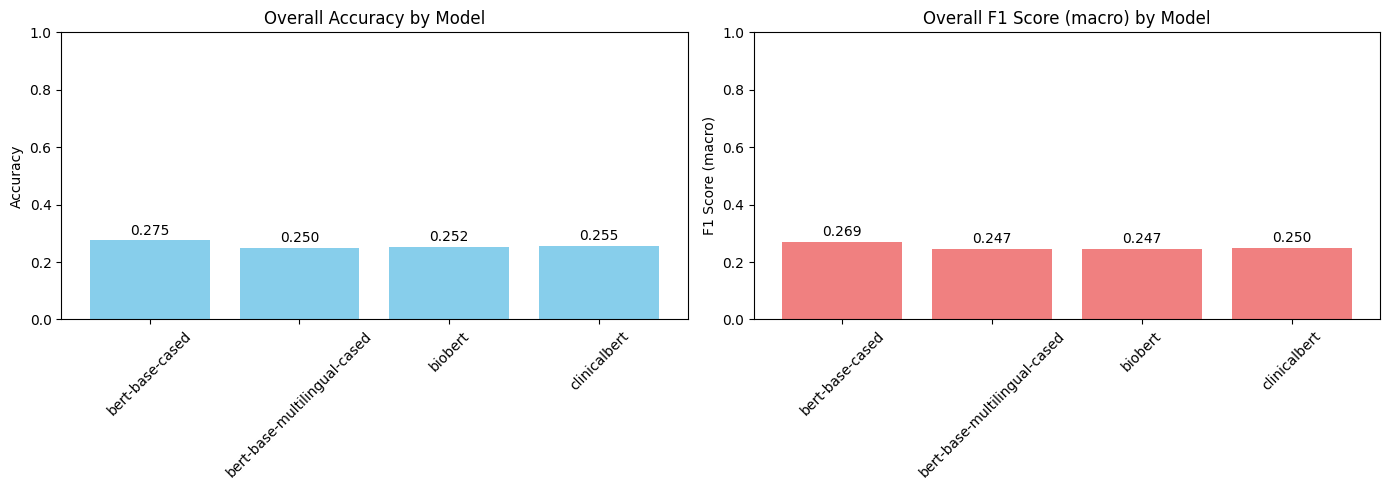

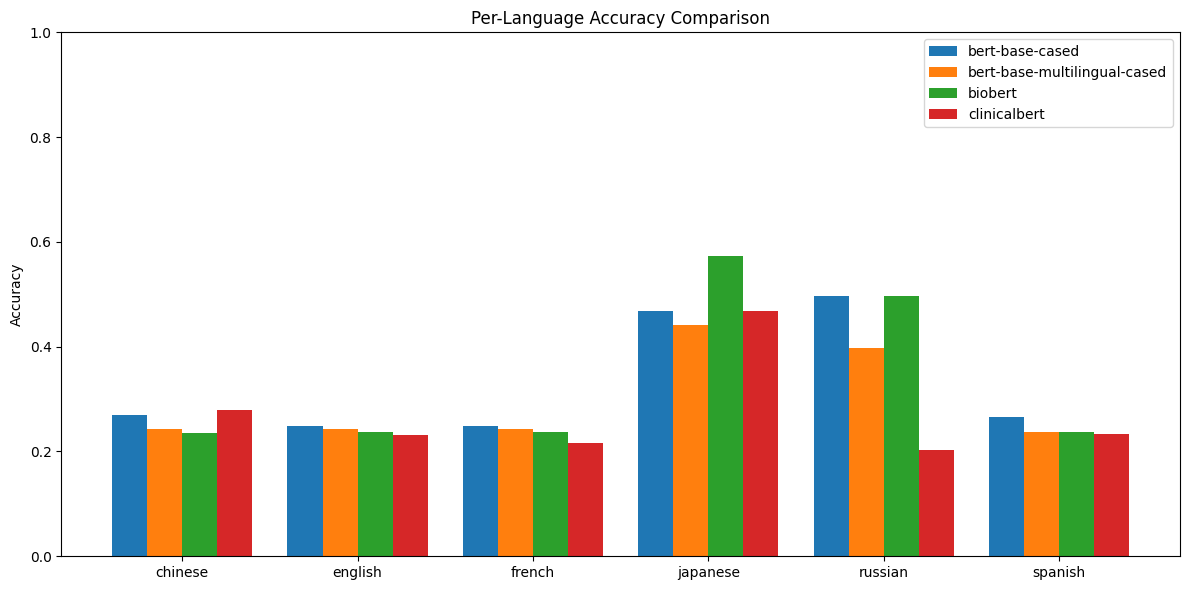

In [ ]:
import matplotlib.pyplot as plt

# Create comparison plots
if len(all_results) > 0:
    # Overall accuracy comparison
    models = [r['model_name'] for r in all_results]
    accuracies = [r['overall_accuracy'] for r in all_results]
    f1_scores = [r['overall_f1_macro'] for r in all_results]

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    # Accuracy plot
    ax1.bar(models, accuracies, color='skyblue')
    ax1.set_ylabel('Accuracy')
    ax1.set_title('Overall Accuracy by Model')
    ax1.set_ylim([0, 1])
    ax1.tick_params(axis='x', rotation=45)
    for i, v in enumerate(accuracies):
        ax1.text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom')

    # F1 score plot
    ax2.bar(models, f1_scores, color='lightcoral')
    ax2.set_ylabel('F1 Score (macro)')
    ax2.set_title('Overall F1 Score (macro) by Model')
    ax2.set_ylim([0, 1])
    ax2.tick_params(axis='x', rotation=45)
    for i, v in enumerate(f1_scores):
        ax2.text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

    # Per-language comparison
    if len(all_results) > 0 and 'per_language' in all_results[0]:
        languages = list(all_results[0]['per_language'].keys())
        fig, ax = plt.subplots(figsize=(12, 6))

        x = np.arange(len(languages))
        width = 0.8 / len(models)

        for i, result in enumerate(all_results):
            lang_accs = [result['per_language'][lang]['accuracy'] for lang in languages]
            ax.bar(x + i * width, lang_accs, width, label=result['model_name'])

        ax.set_ylabel('Accuracy')
        ax.set_title('Per-Language Accuracy Comparison')
        ax.set_xticks(x + width * (len(models) - 1) / 2)
        ax.set_xticklabels(languages)
        ax.legend()
        ax.set_ylim([0, 1])

        plt.tight_layout()
        plt.show()
else:
    print("No results to visualize.")
